In [1]:
import os
import cv2
import pytesseract

# # Get the current working directory and image path
# project_dir = os.getcwd()

# Get the current working directory and move one directory up
project_dir = os.path.dirname(os.getcwd())

# Construct the image path from the project directory
image_path = os.path.join(project_dir, "data_unique", "Original_2.png")

# Load the image
img = cv2.imread(image_path)

# Preprocess the image (if necessary)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# Apply thresholding to make the image binary
_, thresh = cv2.threshold(gray, 150, 255, cv2.THRESH_BINARY)

# Configure Tesseract to recognize digits only and output symbol-level data
custom_config = r'--oem 3 --psm 8 -c tessedit_char_whitelist=0123456789'

# Perform OCR with detailed data output at the symbol level
data = pytesseract.image_to_data(thresh, config=custom_config, output_type=pytesseract.Output.DICT)

# Extract character-level details
recognized_chars = []

n_boxes = len(data['text'])
for i in range(n_boxes):
    text = data['text'][i].strip()
    if text.isdigit():
        recognized_chars.append(text)
# Print the recognized digits
print("Recognized Digits:")
for char in recognized_chars:
    print(f"Number: {char}")


Recognized Digits:
Number: 698492


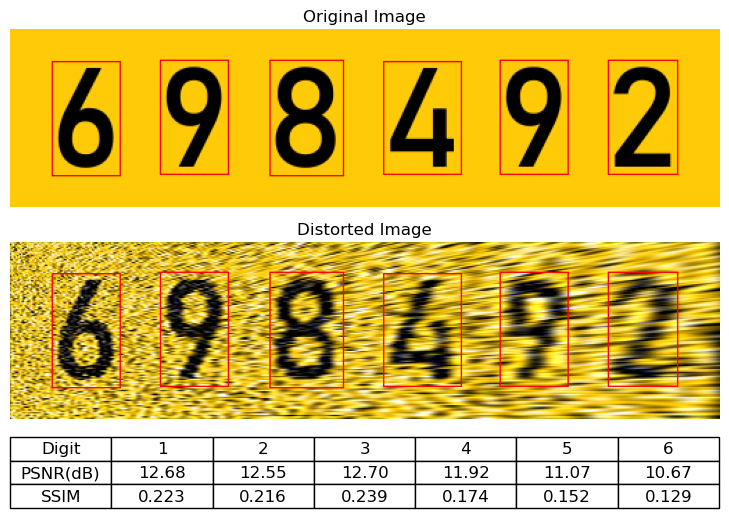

In [2]:

import torch
import torchvision.transforms as transforms
from PIL import Image
import json
import matplotlib.pyplot as plt
import os
import cv2
from pytorch_msssim import ssim
import torch.nn.functional as F

def calculate_psnr_ssim_per_number(original_image_path, distorted_image_path, digit_bboxes):
    """
    Calculates PSNR and SSIM for each digit in the license plate using the bounding boxes with PyTorch.

    Args:
        original_image_path (str): Path to the original image.
        distorted_image_path (str): Path to the distorted image.
        digit_bboxes (list of tuples): List of bounding boxes for each digit [(x1, y1, w, h), ...].

    Returns:
        tuple: Two lists containing PSNR and SSIM values for each digit.
    """
    # Load images
    transform = transforms.ToTensor()
    original_image = transform(Image.open(original_image_path).convert("RGB"))
    distorted_image = transform(Image.open(distorted_image_path).convert("RGB"))

    psnr_values = []
    ssim_values = []

    for bbox in digit_bboxes:
        x, y, w, h = map(int, bbox)  # Ensure coordinates are integers
        x2, y2 = x + w, y + h

        # Extract regions
        original_region = original_image[:, y:y2, x:x2].unsqueeze(0)  # Add batch dimension
        distorted_region = distorted_image[:, y:y2, x:x2].unsqueeze(0)  # Add batch dimension

        # PSNR Calculation
        mse = F.mse_loss(original_region, distorted_region)
        psnr_value = 10 * torch.log10(1.0 / mse)

        psnr_values.append(psnr_value.item())  # Convert to Python float

        # SSIM Calculation
        ssim_value = ssim(distorted_region, original_region, data_range=1.0, size_average=True)
        ssim_values.append(ssim_value.item())  # Convert to Python float

    return psnr_values, ssim_values


# Get the current working directory and image path
index = 2
# project_dir = os.getcwd()
project_dir = os.path.dirname(os.getcwd())
original_image_path = os.path.join(project_dir, f"data_unique/original_{index}.png")
distorted_image_path = os.path.join(project_dir, f"data_unique/distorted_{index}.png")
metadata_path = os.path.join(project_dir, f"data_unique/metadata_{index}.json")

# Load metadata to get digit_bboxes
with open(metadata_path, 'r') as f:
    metadata = json.load(f)
digit_bboxes = metadata['digit_bboxes']

# Show the distorted and the original image with bounding boxes in red
original_image = cv2.imread(original_image_path)
distorted_image = cv2.imread(distorted_image_path)

for bbox in digit_bboxes:
    x, y, w, h = bbox
    cv2.rectangle(original_image, (x, y), (x + w, y + h), (0, 0, 255), 1)
    cv2.rectangle(distorted_image, (x, y), (x + w, y + h), (0, 0, 255), 1)

# Calculate PSNR per number
psnr_per_number, ssim_per_number = calculate_psnr_ssim_per_number(
    original_image_path, distorted_image_path, digit_bboxes)

# Prepare data for the table
table_data = [["Digit", "PSNR(dB)", "SSIM"]]
for i, (psnr, ssim) in enumerate(zip(psnr_per_number, ssim_per_number), start=1):
    table_data.append([str(i), f"{psnr:.2f}", f"{ssim:.3f}"])

# Transpose the table data
transposed_table_data = list(zip(*table_data))

# Display the images using pyplot
plt.figure(figsize=(14, 6))

# Original Image
plt.subplot(2, 1, 1)
plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')

# Distorted Image
plt.subplot(2, 1, 2)
plt.imshow(cv2.cvtColor(distorted_image, cv2.COLOR_BGR2RGB))
plt.title('Distorted Image')
plt.axis('off')

# Adjust the layout to make room for the table
plt.subplots_adjust(left=0.3, bottom=0.3, top=0.95)

# Add the transposed table below the images
table = plt.table(cellText=transposed_table_data,
                  colLabels=None,
                  cellLoc='center',
                  loc='bottom',
                  bbox=[0, -0.5, 1, 0.4])  # [left, bottom, width, height]

table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1, 1)

plt.show()
